In [1]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os import listdir
from os.path import isfile, join

In [2]:
# this is the folder where the NB02 data is stored on your computer
basePath = r'C:\Users\Ted Mburu\NbO2'

# these functions are used in determining the type
# of data we are looking at (posthesh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")


# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, size, fileName):
        self.size = size
        
        if "Sam" in fileName:
            self.version = 2
        else:
            self.version = 1
        
        self.getFileName(fileName) # adds .txt to the file name
        self.getFileDate() # gets the date the data was taken from filename
        self.getSampleNumber() # gets the sample number from filename
        self.getDeviceNumber() # gets the device number from filename
        self.getDoping() # gets the doping percentage from filename
        
        self.NbPercentage = (100 - self.doping) / 100
        self.TiPercentage = self.doping / 100
        self.NbPercentageString = str(self.NbPercentage)
        self.TiPercentageString = str(self.TiPercentage)
        
        # the text displaed on graphs
        sampleText = '  Sample ' + str(self.sampleNumber)
        deviceText = '  Device ' + str(self.deviceNumber)
        nb = 'Nb' if self.NbPercentageString == "1.0" else r'Nb$_{'+ self.NbPercentageString +'}$'
        ti = '' if self.TiPercentageString == "0.0" else r'Ti$_{'+ self.TiPercentageString +'}$'
        self.title = nb + ti + r'O$_2$ 2x2 $\mu$m$^2$,' + sampleText + deviceText
        
        
        self.filePath = self.getFilePath() # combines the filename and base path to get file path
        self.getData() # reads the file and stores the current, voltage and time
        self.removeBadData() # removes all data before the device is burned through
        self.findAllIndexes() # gets the indexes that begin and end every run
        self.sortRuns() # sorts runs into their types and stores them
        self.getLargestGradients() # finds the index of the largest second derivative in each run
        self.getLargestGradientVoltage() # stores the voltage at the largest second derivative
        self.getLargestGradientCurrent() # stores the current at the largest second derivative
#         self.printData() # prints all the important data
#         self.showFinalGraph() # shows a graph with the important data highlighted

    # adds .txt to the file name
    def getFileName(self, fileName):
        self.fileName = fileName + r'.txt'
    
    # combines the filename and base path to get file path
    def getFilePath(self):
        filePath = ''
        if (self.doping  == 5):
            filePath = basePath + r'\Doping05\ '.rstrip()
        elif (self.doping  == 10):
            filePath = basePath + r'\Doping10\ '.rstrip()
        else: 
            filePath = basePath + r'\Doping0\ '.rstrip() 
        filePath = filePath + self.fileName
        return filePath
    
    # gets the date the data was taken from filename
    def getFileDate(self):
        if self.version == 1:
            dateMeasured = self.fileName.split("-")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/" + dateMeasured[4:]
        elif self.version == 2:
            dateMeasured = self.fileName.split("Sam")[1].split("_")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/20" + dateMeasured[4:]
        self.dateMeasured = dateMeasured
        
    # gets the sample number from filename
    def getSampleNumber(self):
        sampleNumber = self.fileName.split("_")[1].split("-")[0]
        self.sampleNumber = sampleNumber
        
    # gets the doping percentage from filename
    def getDoping(self): 
        # the two versions are the filenames with "Sam" in them and the rest
        if self.version == 1: 
            doping = self.fileName.split("IVNb")[1].split("Ti")[0]
            if doping == "1p00":
                doping = 0
            elif doping == "0p100":
                doping = 0
            elif doping == "0p95":
                doping = 5
            elif doping == "0p90":
                doping = 10
            else: 
                print("???")
        elif self.version == 2:
            doping = self.fileName.split("Ti")[1].split("_")[0]
        else:
            print("version?")
        self.doping = int(doping)
        
    # gets the device number from filename
    def getDeviceNumber(self): 
        if self.version == 1:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("-")[1]
            self.deviceNumber = deviceNumber[1:]
        elif self.version == 2:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("_")[1]
            self.deviceNumber = deviceNumber[1:]
    
    # reads the file and stores the current, voltage and time
    def getData(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        self.t = data[:,0]
        self.I = data[:,1]
        self.V = data[:,2]
    
    # removes all data before the device is burned through
    def removeBadData(self):
        largestCurrent = np.amax(self.I)
        maxCurrentThreshhold = largestCurrent * 0.80
        indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)
        
        self.t= self.t[indexOfFirstLargeCurrent:]
        self.I= self.I[indexOfFirstLargeCurrent:]
        self.V= self.V[indexOfFirstLargeCurrent:]
        self.maxCurrentThreshhold = maxCurrentThreshhold
    
    # gets the indexes that begin and end every run
    def findAllIndexes(self):
        allZeroIndexes = []
        zeroIndexes = []
        allMaxIndexes = []
        maxIndexes = []
        newMaxIndexes = []
        allIndexes = []

        # indexes of values that are pretty much 0
        self.zeroThreshhold = 1e-5
        for index, x in enumerate(self.I):
            if x < self.zeroThreshhold:
                allZeroIndexes.append(index)

        # find the zero values that begin or end a run
        zeroIndexes.append(allZeroIndexes[0])
        for x in range(len(allZeroIndexes) - 1):
            if allZeroIndexes[x]+1 != allZeroIndexes[x+1]:
                zeroIndexes.append(allZeroIndexes[x])
                zeroIndexes.append(allZeroIndexes[x+1])
    
        for index, x in enumerate(self.I):
            if x > self.maxCurrentThreshhold:
                allMaxIndexes.append(index)

        # find the max values that start or end a run
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                maxIndexes.append(allMaxIndexes[x])
                maxIndexes.append(allMaxIndexes[x+1])
                
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                newMaxIndexes.append(allMaxIndexes[x]+1)
                newMaxIndexes.append(allMaxIndexes[x+1]+1)
        
        allIndexes = [*zeroIndexes, *maxIndexes]
        allIndexes = sorted(allIndexes)

        for x in range(3, len(allIndexes) - 1, 4):
            allIndexes[x] = allIndexes[x] + 1

        goodRuns = []
        for x in range(0, len(allIndexes) - 4, 4):
            if monotonic( self.V[allIndexes[x]:allIndexes[x+3]] ):
                goodRuns.append(allIndexes[x])
                goodRuns.append(allIndexes[x+1])
                goodRuns.append(allIndexes[x+2])
                goodRuns.append(allIndexes[x+3])

        allIndexes = np.copy(goodRuns)
        self.allIndexes = allIndexes
        self.zeroIndexes = zeroIndexes
        
    # sorts runs into their types and stores them
    def sortRuns(self):
        posThreshValues = []
        negThreshValues = []
        posHoldValues = []
        negHoldValues = []

        timesToLoop = len(self.zeroIndexes) - 1
        for x in range(0, timesToLoop, 2):
            voltageRun = []
            currentRun = []
            timeRun = []
            secondDerivativeRun = []
            start = self.allIndexes[x]
            stop = self.allIndexes[x+1]
            for y in range(start, stop):
                voltageRun.append(self.V[y])
                currentRun.append(self.I[y])
                timeRun.append(self.t[y])
                secondDerivativeRun.append(self.I[y])
            if len(currentRun) > 4:
                secondDerivativeCurrent = np.gradient(np.gradient(currentRun))
                runType = sortIntoSide(voltageRun, currentRun)
                currentRun = [ abs(x) for x in currentRun]
                runData = [timeRun, voltageRun, currentRun, secondDerivativeCurrent]
                if (runType == "posThresh"):
                    posThreshValues.append(runData)
                elif (runType == "posHold"):
                    posHoldValues.append(runData)
                elif (runType == "negThresh"):
                    negThreshValues.append(runData)
                elif (runType == "negHold"):
                    negHoldValues.append(runData)
        self.posThreshValues = posThreshValues
        self.negThreshValues = negThreshValues
        self.posHoldValues = posHoldValues
        self.negHoldValues = negHoldValues
    
    # finds the index of the largest second derivative in each run
    def getLargestGradients(self):
        # take second derivative of each current array
        posThreshValuesGradients = []
        negThreshValuesGradients = []
        posHoldValuesGradients = []
        negHoldValuesGradients = []

        for x in self.posThreshValues:
            posThreshValuesGradients.append(x[3])
        for x in self.negThreshValues:
            negThreshValuesGradients.append(x[3])
        for x in self.posHoldValues:
            posHoldValuesGradients.append(x[3])
        for x in self.negHoldValues:
            negHoldValuesGradients.append(x[3])
            
        self.posThreshValuesGradients = posThreshValuesGradients
        self.negThreshValuesGradients = negThreshValuesGradients
        self.posHoldValuesGradients = posHoldValuesGradients
        self.negHoldValuesGradients = negHoldValuesGradients

        # find the index of the largest value in the 2nd derivative
        posThreshValuesLargestGradient = []
        negThreshValuesLargestGradient = []
        posHoldValuesLargestGradient = []
        negHoldValuesLargestGradient = []

        for x in posThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posThreshValuesLargestGradient.append(largestValue)
        for x in negThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negThreshValuesLargestGradient.append(largestValue)
        for x in posHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posHoldValuesLargestGradient.append(largestValue)
        for x in negHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negHoldValuesLargestGradient.append(largestValue)
            
        self.posThreshValuesLargestGradient = posThreshValuesLargestGradient
        self.negThreshValuesLargestGradient = negThreshValuesLargestGradient
        self.posHoldValuesLargestGradient = posHoldValuesLargestGradient
        self.negHoldValuesLargestGradient = negHoldValuesLargestGradient
    
    # stores the voltage at the largest second derivative
    def getLargestGradientVoltage(self):
        posThreshValuesVoltage = []
        negThreshValuesVoltage = []
        posHoldValuesVoltage = []
        negHoldValuesVoltage = []

        for x in range(len(self.posThreshValuesGradients)):
            voltage = self.posThreshValues[x][1][self.posThreshValuesLargestGradient[x]]
            posThreshValuesVoltage.append(voltage)
        for x in range(len(self.negThreshValuesGradients)):
            voltage = self.negThreshValues[x][1][self.negThreshValuesLargestGradient[x]]
            negThreshValuesVoltage.append(voltage)
        for x in range(len(self.posHoldValuesGradients)):
            voltage = self.posHoldValues[x][1][self.posHoldValuesLargestGradient[x]]
            posHoldValuesVoltage.append(voltage)
        for x in range(len(self.negHoldValuesGradients)):
            voltage = self.negHoldValues[x][1][self.negHoldValuesLargestGradient[x]]
            negHoldValuesVoltage.append(voltage)
        
        self.posThreshValuesVoltage = posThreshValuesVoltage
        self.negThreshValuesVoltage = negThreshValuesVoltage
        self.posHoldValuesVoltage = posHoldValuesVoltage
        self.negHoldValuesVoltage = negHoldValuesVoltage
        
    # stores the current at the largest second derivative
    def getLargestGradientCurrent(self):
        posThreshValuesCurrent = []
        negThreshValuesCurrent = []
        posHoldValuesCurrent = []
        negHoldValuesCurrent = []

        for x in range(len(self.posThreshValuesGradients)):
            current = self.posThreshValues[x][2][self.posThreshValuesLargestGradient[x]]
            posThreshValuesCurrent.append(current)
        for x in range(len(self.negThreshValuesGradients)):
            current = self.negThreshValues[x][2][self.negThreshValuesLargestGradient[x]]
            negThreshValuesCurrent.append(current)
        for x in range(len(self.posHoldValuesGradients)):
            current = self.posHoldValues[x][2][self.posHoldValuesLargestGradient[x]]
            posHoldValuesCurrent.append(current)
        for x in range(len(self.negHoldValuesGradients)):
            current = self.negHoldValues[x][2][self.negHoldValuesLargestGradient[x]]
            negHoldValuesCurrent.append(current)
        
        self.posThreshValuesCurrent = posThreshValuesCurrent
        self.negThreshValuesCurrent = negThreshValuesCurrent
        self.posHoldValuesCurrent = posHoldValuesCurrent
        self.negHoldValuesCurrent = negHoldValuesCurrent
    
    # prints all the important data
    def printData(self):
        averages = []
        averages[0] = average(self.posThreshValuesVoltage)
        averages[1] = average(self.negThreshValuesVoltage)
        averages[2] = average(self.posHoldValuesVoltage)
        averages[3] = average(self.negHoldValuesVoltage)
        
        standardDeviations = []
        standardDeviations[0] = np.std(self.posThreshValuesVoltage)
        standardDeviations[1] = np.std(self.negThreshValuesVoltage)
        standardDeviations[2] = np.std(self.posHoldValuesVoltage)
        standardDeviations[3] = np.std(self.negHoldValuesVoltage)
        
        print("Positive Threshold Voltage: ", averages[0] , "Standard Deviation: ", standardDeviations[0])
        print("Negative Threshold Voltage: ", averages[1], "Standard Deviation: ", standardDeviations[1])
        print("Positive Hold Voltage: ", averages[2], "Standard Deviation: ", standardDeviations[2])
        print("Negative Hold Voltage: ", averages[3], "Standard Deviation: ", standardDeviations[3])
        print()
        
    # shows a graph with the important data highlighted
    def showFinalGraph(self):
        plt.rcParams['figure.figsize'] = (11,6)
        plt.figure(len(files))
        plt.grid()
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)');
        plt.ylabel('Current (A)');

        plt.axhline(y=self.maxCurrentThreshhold, color='r', linestyle='-')
        plt.axhline(y=self.zeroThreshhold, color='r', linestyle='-')

        if len(self.posThreshValuesVoltage) > 1:
            voltage = average(self.posThreshValuesVoltage)
            current = average(self.posThreshValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.posThreshValuesVoltage), fmt="ro")

        if len(self.negThreshValuesVoltage) > 1:
            voltage = average(self.negThreshValuesVoltage)
            current = average(self.negThreshValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.negThreshValuesVoltage), fmt="bo")

        if len(self.posHoldValuesVoltage) > 1:
            voltage = average(self.posHoldValuesVoltage)
            current = average(self.posHoldValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.posHoldValuesVoltage), fmt="go")

        if len(self.negHoldValuesVoltage) > 1:
            voltage = average(self.negHoldValuesVoltage)
            current = average(self.negHoldValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.negHoldValuesVoltage), fmt="yo")

        plt.title(self.title);

class DataSet:
    def __init__(self, size, vThresh, vHold):
        self.size = size
        self.vThresh = vThresh
        self.vHold = vHold
        self.cycles = list(range(1,len(vThresh) + 1))


In [3]:
# files = [] # stores all the files data as DataFile objects

# # creating the objects as indices in the files array
# #                     size, fileName
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam13_060622_10a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam13_060622_11b'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam13_060622_12a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D1'))
# # files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051922_D2'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051922_D3'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051922_D4'))
# files.append(DataFile("4x4", r'IVs_NbO2_Ti10_Sam24_051922_D5'))
# files.append(DataFile("20x20", r'IVs_NbO2_Ti10_Sam24_051922_D6'))
# files.append(DataFile("8x8", r'IVs_NbO2_Ti10_Sam24_051922_D7'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_052022_D8'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_052022_D9'))
# # files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_060722_D10a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_060722_D12a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_060722_D15a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D16'))
# # files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D17'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D18'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D19'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D20'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051722_D21'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D22'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060122_01a'))
# files.append(DataFile("4x4", r'IVs_NbO2_Ti0_Sam2_2nd_060222_04a'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti0_Sam2_2nd_060322_06a'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_07a'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_08b'))
# # files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_08a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060322_09a'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060622_12a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_13a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_14a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_15a'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_16a'))
# files.append(DataFile("4x4", r'IVs_NbO2_Ti0_Sam2_2nd_060622_17a'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060622_18a'))


# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-01b'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-02a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-03a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-04a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-06a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-07a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-08a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-09a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-10a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-11a'))
# # files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_13-03222022-12a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-13a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-14a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-15b'))
# # files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_13-03242022-16a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-17a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-18a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-19a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-20a'))
# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-21a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-22a'))


# # files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_02-04072022-1a'))
# # files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_02-04072022-02a'))
# # files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_02-04072022-03a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_02-04072022-04a'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-05a'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-06a'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-07a'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-08'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-11'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04282022-22'))
# # files.append(DataFile("15x15", r'IVNb0p100Ti0p00O2_02-04262022-13'))
# files.append(DataFile("3x3", r'IVNb0p100Ti0p00O2_02-04262022-14'))
# files.append(DataFile("3x3", r'IVNb0p100Ti0p00O2_02-04282022-21'))
# files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04262022-15'))
# files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04262022-16'))

# files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04282022-18a'))
# files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04282022-19'))
# files.append(DataFile("10x10", r'IVNb0p100Ti0p00O2_02-04262022-17'))
# files.append(DataFile("15x15", r'IVNb0p100Ti0p00O2_02-04282022-20'))


# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02112022-05-a'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02112022-06-a'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-b'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-c'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-d'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-f'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-08-a'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-08-aa'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-e'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-h'))
# # files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-i'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-9'))
# # files.append(DataFile("5x5", r'IVNb0p95Ti0p05O2_13-02182022-10-b'))
# # files.append(DataFile("15x15", r'IVNb0p95Ti0p05O2_13-03212022-13'))
# files.append(DataFile("15x15", r'IVNb0p95Ti0p05O2_13-03212022-14'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-16'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-17'))

# # files.append(DataFile("2x2", r''))

In [4]:
# # goes through all the DataFiles and stores the first occurance of each new size
# allSizes = []
# for x in range(len(files)):
#     allSizes.append(files[x].size)
# allSizes = pd.unique(allSizes)

# # gets the number before the "x" in the device size so they can be sorted
# newAllSizes = []
# for size in allSizes:
#     newAllSizes.append(int(size.split("x")[0]))
# newAllSizes.sort()

# allSizes = []

# for size in newAllSizes:
#     allSizes.append(str(size) + "x" + str(size))

# print(allSizes)

# # goes through all the DataFiles and stores the first occurance of each new doping amount
# # they're sorted by default 
# allDoping= []
# for x in range(len(files)):
#     allDoping.append(files[x].doping)
# allDoping = np.unique(allDoping)
# print(allDoping)

In [5]:
# # this is the data that will be plotted
# ourData = []

# # go though all the files sizes and the unique, sorted device sizes and 
# # if they match, add them to their index in data to be plotted
# for size in allSizes:
#     threshVoltage = []
#     holdVoltage = []
#     for file in files:
#         if file.size == size:
#             # combines the neg and pos thesh and hold voltages and makes them positive 
#             threshVoltageArray = np.concatenate((file.posThreshValuesVoltage, file.negThreshValuesVoltage), axis=0)
#             threshVoltageArray = np.absolute(threshVoltageArray)
#             threshVoltage = np.append(threshVoltage, threshVoltageArray)
#             holdVoltageArray = np.concatenate((file.posHoldValuesVoltage, file.negHoldValuesVoltage), axis=0)
#             holdVoltageArray = np.absolute(holdVoltageArray)
#             holdVoltage = np.append(holdVoltage, holdVoltageArray)
#     ourData.append(threshVoltage)
#     ourData.append(holdVoltage)
# #     print(data[0])

In [11]:
# Karsen's Data

filePath = r"C:\Users\Ted Mburu\NbO2\SelectorIV\CompleteData_negative.csv"
df5 = pd.read_csv(filePath, names=['Time (s)','Current (A)','Voltage (V)'],sep='\t',skiprows=1)
karsensdata = df5.values
df5.head()

karsensnegativeVoltages = []
karsensnegativeSizes = karsensdata[1][0].split(",")

for x in range(1, len(karsensnegativeSizes)):
    karsensnegativeSizes[x] = karsensnegativeSizes[x][:-2]
    karsensnegativeSizes[x] = karsensnegativeSizes[x] + "x" + karsensnegativeSizes[x] + r" nm$^2$"
    
karsensuniqueNegSizes = []
for x in range(len(karsensnegativeSizes)):
    karsensuniqueNegSizes.append(karsensnegativeSizes[x])
karsensuniqueNegSizes = pd.unique(karsensuniqueNegSizes)[1:]

karsenssizes = [karsensnegativeSizes[3], karsensnegativeSizes[11], karsensnegativeSizes[19], karsensnegativeSizes[27], karsensnegativeSizes[35]]
karsensvThreshColumns = [3, 11, 19, 27, 35]
karsensvHoldColumns = [7, 15, 23, 31, 39]

for x in range(len(karsenssizes)):
    karsensvThresh = []
    karsensvHold = []
    for y in range(2, 1002):
        rowData = karsensdata[y][0].split(",")
        karsensvThresh.append(rowData[karsensvThreshColumns[x]])
        karsensvHold.append(rowData[karsensvHoldColumns[x]])
    karsensnegativeVoltages.append(DataSet(karsenssizes[x], np.array(karsensvThresh), np.array(karsensvHold)))

In [12]:
filePath = r"C:\Users\Ted Mburu\NbO2\SelectorIV\CompleteData_positive.csv"
df5 = pd.read_csv(filePath, names=['Time (s)','Current (A)','Voltage (V)'],sep='\t',skiprows=1)
data = df5.values
df5.head()
    
karsenspositiveVoltages = []
karsenspositiveSizes = karsensdata[1][0].split(",")

for x in range(len(karsenssizes)):
    karsensvThresh = []
    karsensvHold = []
    for y in range(2, 1002):
        rowData = karsensdata[y][0].split(",")
        karsensvThresh.append(rowData[karsensvThreshColumns[x]])
        karsensvHold.append(rowData[karsensvHoldColumns[x]])
    karsenspositiveVoltages.append(DataSet(karsenssizes[x], np.array(karsensvThresh), np.array(karsensvHold)))

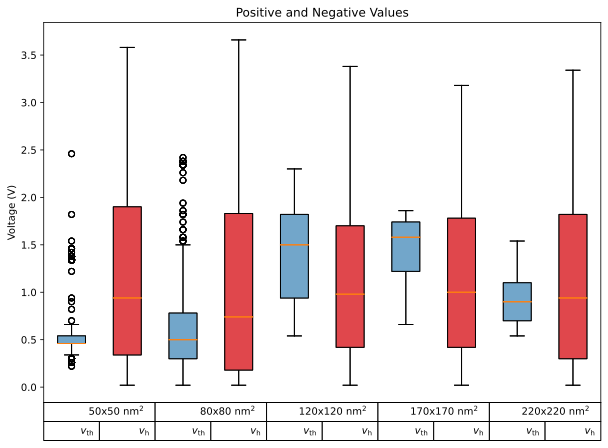

In [13]:
fig, ax = plt.subplots(figsize =(10, 7))
 
# Creating plot
karsensdataToPlot = []

# print(negativeVoltages[0].vThresh)

for size in karsensuniqueNegSizes:
    for x in range(len(karsensnegativeVoltages)):
#         print(negativeVoltages[x].vThresh[0])
        if karsensnegativeVoltages[x].size == size:
            karsensnegVThresh = np.absolute(karsensnegativeVoltages[x].vThresh.astype(np.float64))
            karsensnegVHold = np.absolute(karsensnegativeVoltages[x].vHold.astype(np.float64))
            karsensposVThresh = np.absolute(karsenspositiveVoltages[x].vThresh.astype(np.float64))
            karsensposVHold = np.absolute(karsenspositiveVoltages[x].vHold.astype(np.float64))
            
#             print(negVHold[0])
            
            karsensdataToPlot.append(np.concatenate((karsensnegVThresh, karsensposVThresh)))
            karsensdataToPlot.append(np.concatenate((karsensnegVHold, karsensposVHold)))

plt.boxplot(karsensdataToPlot)

title = "Positive and Negative Values"
ax.set_title(title)
ax.set_ylabel('Voltage (V)')


box = plt.boxplot(karsensdataToPlot, patch_artist=True)
 
red = [224/255, 71/255, 76/255]
blue = [114/255, 166/255, 202/255]

colors = [blue, red, blue, red, blue, red, blue, red, blue, red]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Plot bars and create text labels for the table
cell_text = [karsensuniqueNegSizes]
plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])
holdText = r"$v_\mathrm{h}$"
treshText = r"$v_\mathrm{th}$"
cell_text = [[treshText, holdText, treshText, holdText, treshText, holdText, treshText, holdText, treshText, holdText]]
plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])

# nValues = []
# for x in range(len(negativeVoltages)):
#     nValues.append("n = " + str(len(negativeVoltages[x].vThresh)))
    
# mValues = []
# for x in range(len(negativeVoltages)):
#     mValues.append("m = 100")

# cell_text = [[nValues[0], nValues[1], nValues[2], nValues[3], nValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.15, 1, 0.05])

# cell_text = [[mValues[0], mValues[1], mValues[2], mValues[3], mValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.2, 1, 0.05])

plt.xticks([])
# show plot
# plt.savefig(title + r'.pdf', bbox_inches = 'tight')
plt.show() 

# print(len(negativeVoltages[0].vThresh))
# we have micro meters
# these are nm

# 80 thesh is too low

# add maximum on distribution
# add color to the plot blue red

# send matt positives, negatives, both graphs

# label y axis

NameError: name 'ourData' is not defined

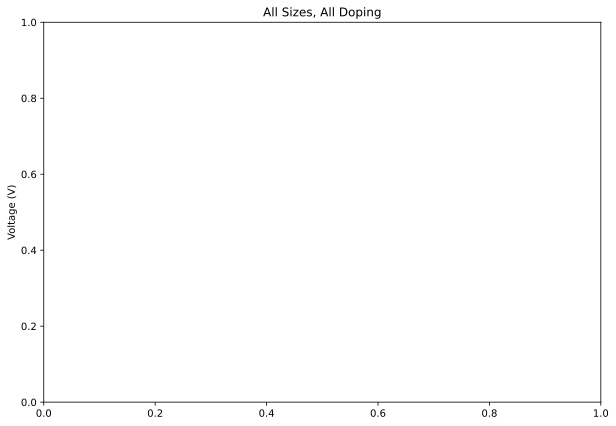

In [9]:
# creates the box and whisker plot
fig, ax = plt.subplots(figsize =(10, 7))
 
# Creating plot
title = "All Sizes, All Doping"
ax.set_title(title)
ax.set_ylabel('Voltage (V)')
box = plt.boxplot(ourData, patch_artist=True)

# colors for the plot in rgb
# values must be between 0 and 1
red = [224/255, 71/255, 76/255]
blue = [114/255, 166/255, 202/255]

colors = [blue, red, blue, red, blue, red, blue, red, blue, red, blue, red, blue, red]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# create text labels for the table at the bottom
cell_text = [allSizes]
plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])
cell_text = []

cell_text = [["vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho"]]
plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])

plt.xticks([])
# show plot
plt.savefig(title + r'.pdf', bbox_inches = 'tight')
plt.show() 
